In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
seed = 2

- [Introduction](#Introduction)

- [First Steps](#First-Steps) 

    - [Downloading the dataset](#Downloading-the-dataset)

    - [Loading the dataset & prep](#Loading-the-dataset-&-prep)
    
- [Investigating the dataset](#Investigating-the-dataset)

    - [Cover Type and Feature distributions](#Cover-Type-and-Feature-distributions)
    
    - [Relationships between features](#Relationships-between-features)
    
    - [Relationships between features and cover type](#Relationships-between-features-and-cover-type)
    
- [Modeling](#Modeling)

    - [Preprocessing data](#Preprocessing-data)
    
    - [Model creation](#Model-creation)
    
        - [Seup](#Setup)
        
        - [Unsplit models](#Unsplit-models)
        
        - [Split models](#Split-models)

# Introduction

This notebook uses the Covertype data set accessible at https://archive.ics.uci.edu/ml/datasets/covertype

The dataset description given there states, in part:

> Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

> This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices."


The attributes within the data set are as follows.

__Elevation__ -- Elevation in meters.

__Aspect__ -- Aspect in degrees.

__Slope__ -- Slope in degrees.

__Horizontal distance to hydrology__ -- Horizontal distance in meters to nearest surface water.

__Vertical distance to hydrology__ -- Vertical distance in meters to nearest surface water.

__Horizontal distance to roadway__ -- Horizontal distance in meters to nearest roadway.

__Hillshade 9am__ -- Index scaled from 0 to 255.

__Hillshade noon__ -- Index scaled from 0 to 255.

__Hillshade 3pm__ -- Index scaled from 0 to 255.

__Horizontal distance to fire point__ -- Horizontal distance in meters to nearest wildfire ignition point.

__Wildernesss__ -- 4 one hot encoded columns representing wilderness type.

__Soil__ -- 40 one hot encoded columns representing soil type.

__Cover type__ -- Integer representing cover type.





# First Steps

## Downloading the dataset

In [2]:
#Download dataset and decompress to obtain csv file.

#import wget

#wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz", "covtypedata.gz")

#import gzip
#import shutil

# with gzip.open("covtypedata.gz", "rb") as f_in:
#     with open("covtypedata.csv", "wb") as f_out:
#         shutil.copyfileobj(f_in,f_out)  

## Loading the dataset & prep

In [3]:
##Set up column names

num_column_names = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",\
                            "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadway",\
                            "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Disance_To_Fire_Points"]


wilderness_oh_cols = ["Wilderness_{}".format(i) for i in range(1,5)]

soil_oh_cols = ["Soil_{}".format(i) for i in range(1,41)]

oh_columns = wilderness_oh_cols + soil_oh_cols


features = num_column_names + oh_columns

columns = features + ["Cover_Type"]

##Read csv

cover = pd.read_csv("covtypedata.csv", names = columns)

In [4]:
print("Total length: \n{}\n".format(len(cover)))

print("Total missing: \n{}\n".format(cover.isna().sum().sum()))

print("Number of one hot encoded rows is equal to total length: \nWilderness: {} \nSoil: {}\n".format(\
                    (cover[wilderness_oh_cols].to_numpy().sum(axis = 1) == 1).sum() == len(cover),\
                    (cover[soil_oh_cols].to_numpy().sum(axis = 1) == 1).sum() == len(cover)))

Total length: 
581012

Total missing: 
0

Number of one hot encoded rows is equal to total length: 
Wilderness: True 
Soil: True



In [5]:
cover.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadway,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Disance_To_Fire_Points,...,Soil_32,Soil_33,Soil_34,Soil_35,Soil_36,Soil_37,Soil_38,Soil_39,Soil_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Both the Wilderness and Soil variables are one hot encoded. It will be easier to investigate them using single column versions that use integers.

In [6]:
def oh_to_integers(df, cols, name, starting = 1):
    oh = df[cols].to_numpy()
    length = len(cols)
    column = np.matmul(oh, np.arange(starting, length + starting).T)
    column = pd.Series(column, name = name)
    df[name] = column
    return

#Converting one hot to integers

oh_to_integers(cover, wilderness_oh_cols, "wilderness")
oh_to_integers(cover, soil_oh_cols, "soil")

In [7]:
# Split training and test data

g = cover.groupby("Cover_Type", group_keys = False)

train_indices = g.apply(lambda x: x.sample(int(.8 * len(x)), random_state = seed)).index

test_indices = [i for i in range(len(cover)) if i not in train_indices]

print("Number of samples in training set: {}".format(len(train_indices)))
print("Number of samples in testing set: {}".format(len(test_indices)))

cover_train = cover.loc[train_indices]
cover_test = cover.loc[test_indices]

Number of samples in training set: 464807
Number of samples in testing set: 116205


# Investigating the dataset

In [8]:
cover_train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadway,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Disance_To_Fire_Points,...,Soil_34,Soil_35,Soil_36,Soil_37,Soil_38,Soil_39,Soil_40,Cover_Type,wilderness,soil
count,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,...,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000,464807.000000
mean,2959.521804,155.725671,14.096122,269.452818,46.376705,2350.677328,212.131190,223.330922,142.568051,1980.830280,...,0.002754,0.003259,0.000198,0.000523,0.026904,0.023709,0.014972,2.051460,2.114908,24.367159
std,279.904746,111.957527,7.485175,212.657934,58.255875,1559.549565,26.750715,19.771245,38.229226,1325.248794,...,0.052405,0.056998,0.014067,0.022859,0.161802,0.152140,0.121440,1.396497,1.061090,9.482215
min,1859.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,20.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,29.000000
75%,3164.000000,261.000000,18.000000,390.000000,69.000000,3329.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,31.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7112.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,40.000000


## Cover type and feature distributions

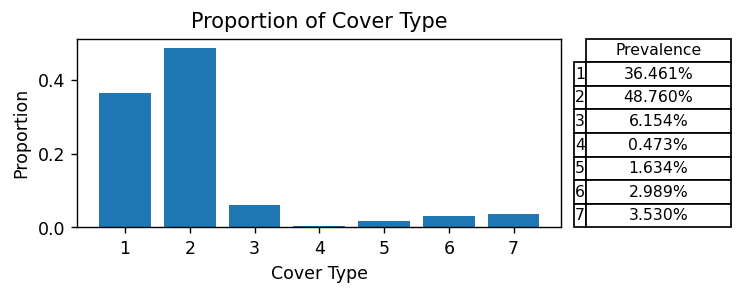

In [9]:
type_counts = cover_train.value_counts("Cover_Type", normalize = True, sort = False)
plt.figure(figsize = (5,2), dpi = 125)
plt.bar(type_counts.index, type_counts.values)
plt.xlabel("Cover Type")
plt.ylabel("Proportion")
plt.title("Proportion of Cover Type")
table = plt.table([["{:.3%}".format(a)] for a in type_counts.values], rowLabels = type_counts.index.to_list(),\
        loc = "left", cellLoc = "center", bbox = [1.05,0,.3,1], colLabels = ["Prevalence"])
table.auto_set_font_size(False)
table.set_fontsize(9)
plt.show()

There is a clear imbalance between the cover types. Notably, type 2 is nearly half the dataset on its own, and types 1 and 2 make up just over 85%. Type 4, on the other hand, is not even 0.5% of the dataset. There is a risk that training without accounting for this will result in a model that performs poorly on cover types other than 1 and 2.

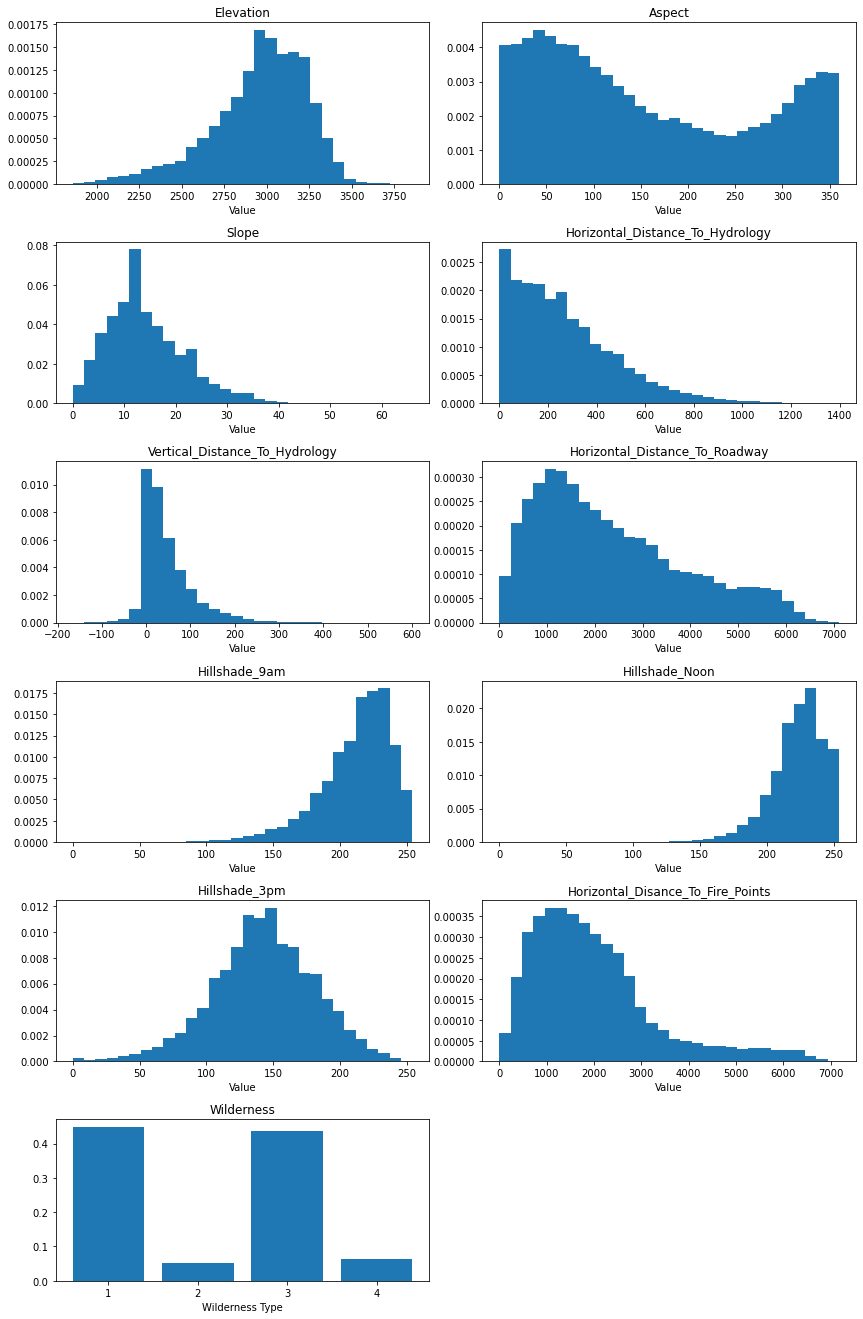

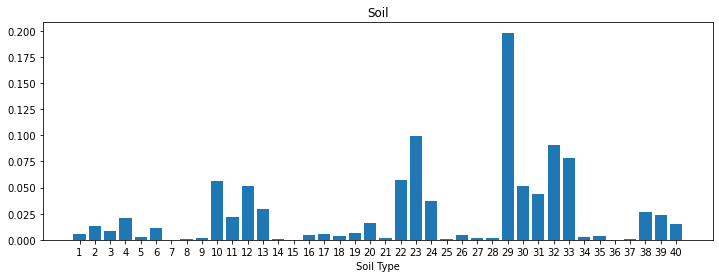

In [10]:
## Histograms for each feature except wilderness and soil

counter = 1
plt.figure(figsize = (12,18))
for feature in num_column_names:
    plt.subplot(len(num_column_names) //2 + 1, 2, counter)
    plt.hist(cover_train.loc[:,feature], bins = 30, density = True)
    plt.title(feature)
    plt.xlabel("Value")
    counter += 1
plt.tight_layout()    

## Bar charts for wilderness and soil

W = cover_train.wilderness.value_counts(normalize = True)
S = cover_train.soil.value_counts(normalize = True, sort = False)

plt.subplot(len(num_column_names) // 2 + 1, 2, counter)
plt.bar(W.index, W.values)
plt.xticks(labels = [i for i in range(1,5)], ticks = [i for i in range(1,5)])
plt.title("Wilderness")
plt.xlabel("Wilderness Type")
plt.show()

plt.figure(figsize = (12,4))
plt.bar(S.index, S.values)
plt.xticks(labels = [i for i in range(1,41)], ticks = [i for i in range(1,41)])
plt.title("Soil")
plt.xlabel("Soil Type")
plt.show()

Looking at distributions of the numerical features, there isn't anything immediately striking. Both vertical and horizontal distance to hydrology are heavily clustered towards low values. The vertical distance is negative in some cases, but that isn't problematic since the nearest water source could be above or below the location. 

Wilderness types 2 and 4 are much less prevalent that types 1 and 3, which make up over 80% of the data.

Soil types are also far from uniformly distributed. Notably, soil type 29 makes up nearly 20% on its own. On the other extreme there are 3 samples, out of over 500,000, with soil type 15. The details are more easily seen in the table below.

In [11]:
soil_table = cover_train.groupby("soil").\
apply(lambda x: pd.Series({"Count": len(x), "Proportion": "{:.3%}".format(len(x)/len(cover_train))})).\
sort_values(by = "Count")

soil_table

,Count,Proportion
soil,,
15,3,0.001%
7,80,0.017%
36,92,0.020%
8,135,0.029%
37,243,0.052%
25,378,0.081%
14,467,0.100%
21,668,0.144%
28,757,0.163%


## Relationships between features

Let's look at the relationships between features now. To begin with, we will find pairs of highly correlated features to see if any obvious redundancy can be removed.

In [12]:
def high_corr(df,cols,threshold):
    l = len(cols)
    Cov = df[cols].corr().abs()
    high_corr_pairs = [(i,j) for i in cols for j in cols[cols.index(i)+1:] if Cov.loc[i,j] > threshold]
    return high_corr_pairs

highly_correlated = high_corr(cover_train,num_column_names, .9)
print("Highly correlated features:")
print(highly_correlated)

Highly correlated features:
[]


None of the numerical features are highly correlated, but it is still worth looking for relationships more complicated than linear ones.

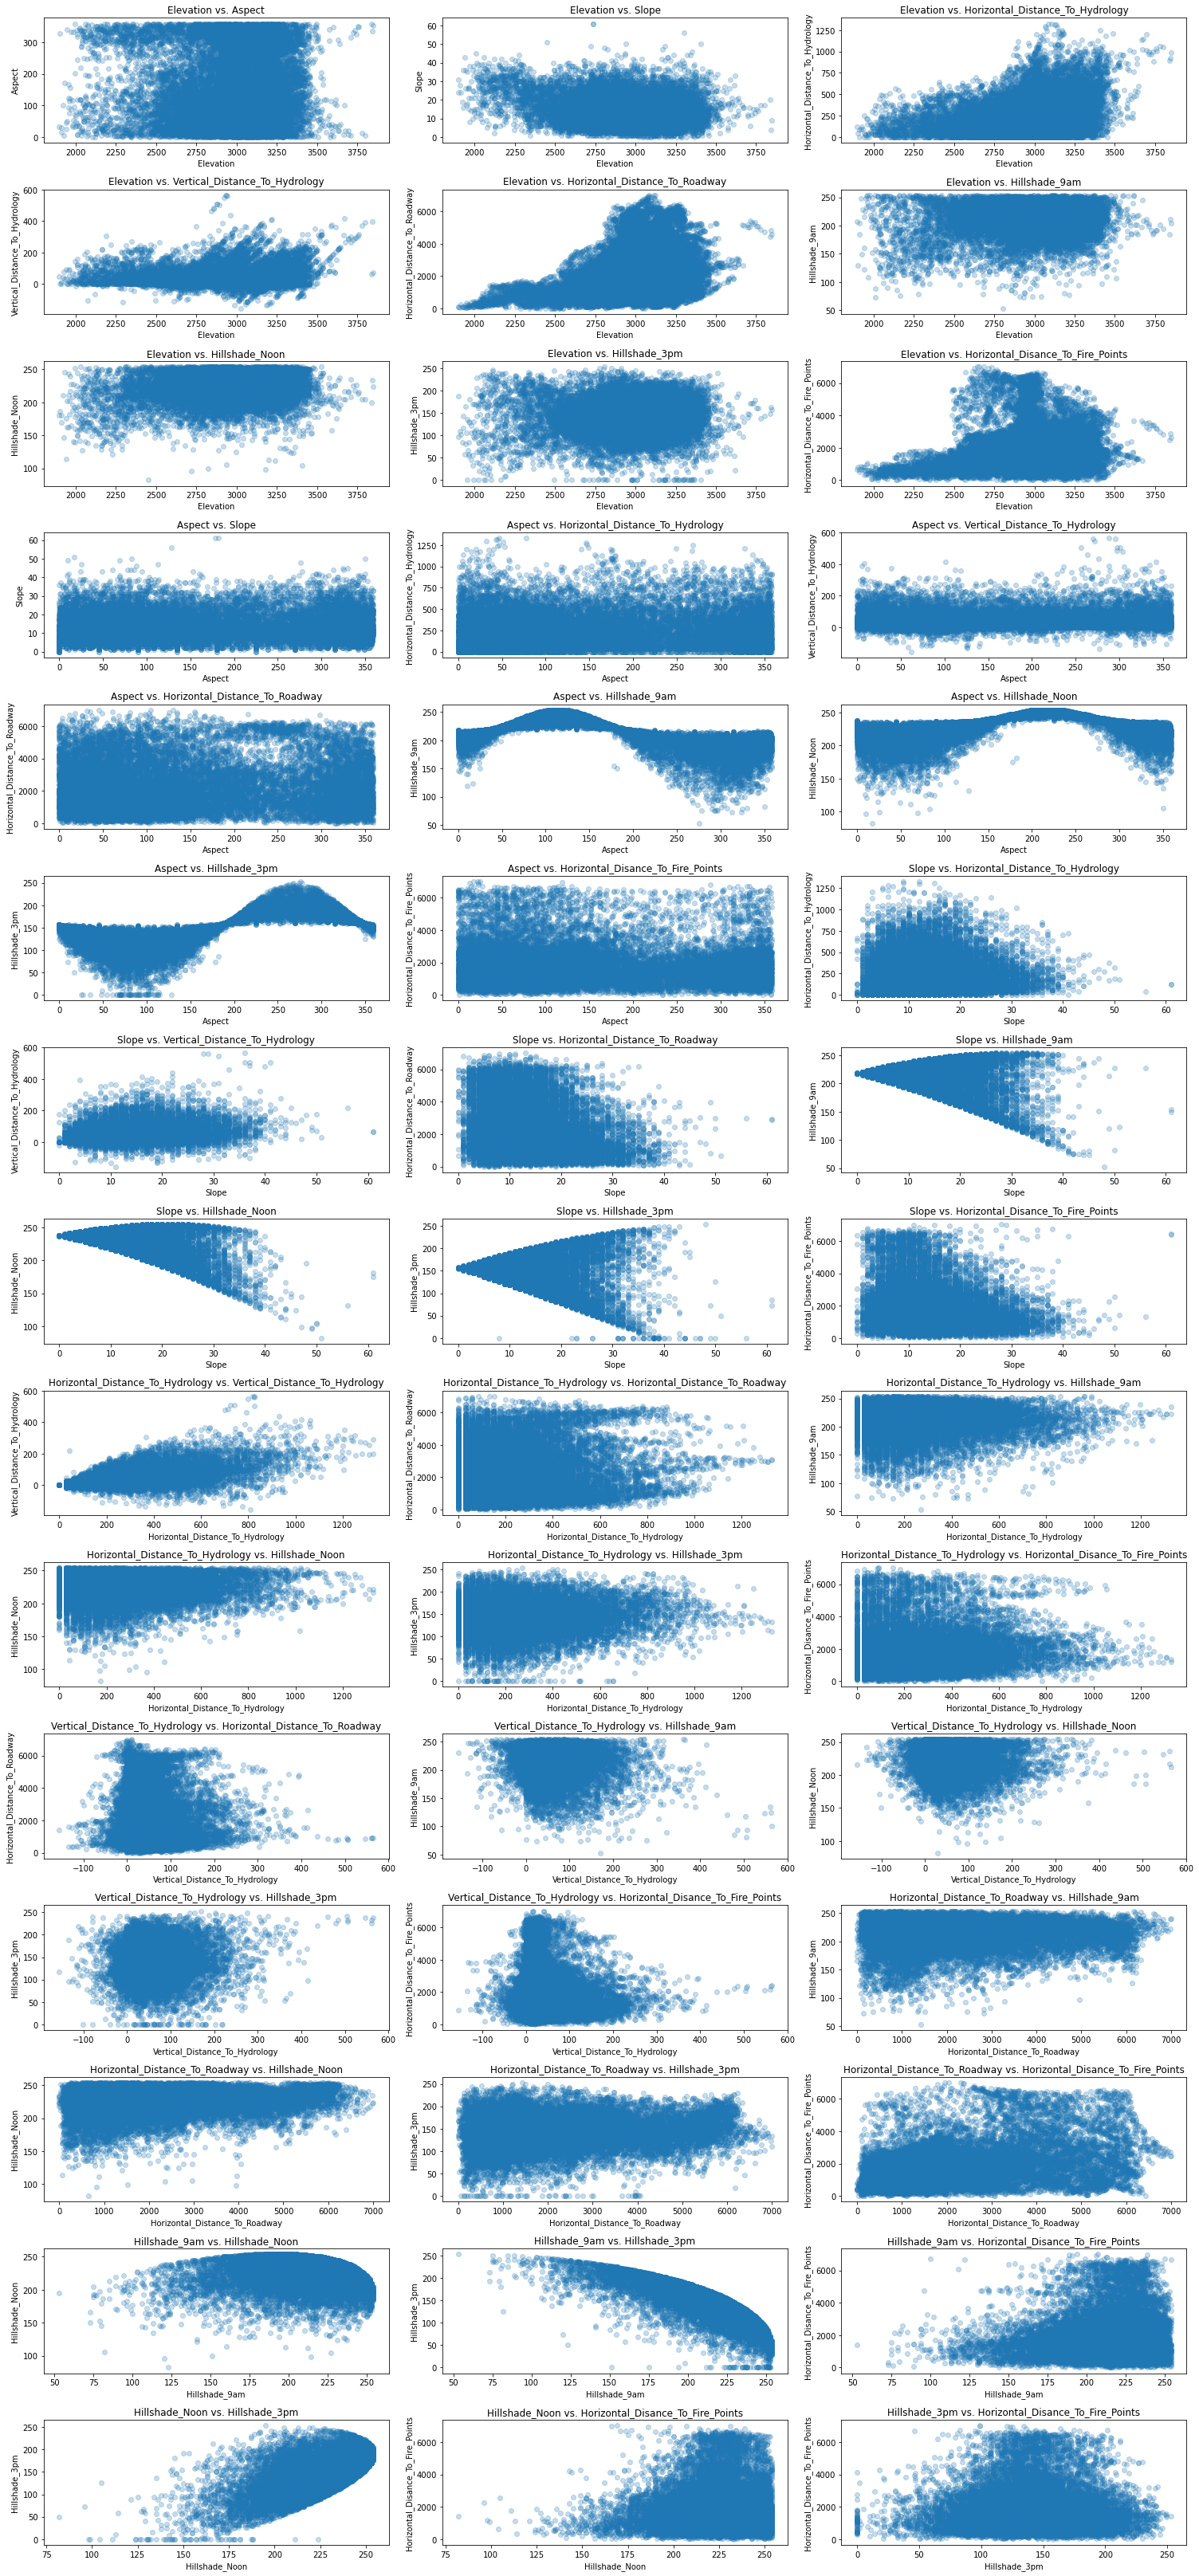

In [13]:
counter = 1
plt.figure(figsize = (21,45))

for i in range(len(num_column_names)):
    for j in range(i+1,len(num_column_names)):
        plt.subplot(15,3,counter)
        f1 = num_column_names[i]
        f2 = num_column_names[j]
        plt.scatter(cover_train[f1][::25], cover_train[f2][::25], alpha = .25)
        plt.title("{} vs. {}".format(f1, f2))
        plt.xlabel("{}".format(f1))
        plt.ylabel("{}".format(f2))
        counter += 1
        
plt.tight_layout()
plt.show()

There are clear relationships between the three Hillshade features with eachother, as well as the aspect and slope features.

In [14]:
def binner(df, col, bins = 7):
    cut = pd.cut(df[col], bins = bins)
    right = cut.apply(lambda x: x.right)
    return right


def two_d_graph(df, col1, col2s, colors):
    counter = 1
    for col2 in col2s:
        plt.subplot(1,len(col2s),counter)
        plt.scatter(df[col1][::10], df[col2][::10], alpha = .5, c = colors[::10])
        plt.xlabel(col1, fontsize = 12)
        plt.ylabel(col2, fontsize = 12)
        plt.title("{} vs. {}".format(col1, col2), fontsize = 12)
        cb = plt.colorbar()
        cb.ax.set_xlabel("Slope", rotation = 0, fontsize = 12)
        counter += 1

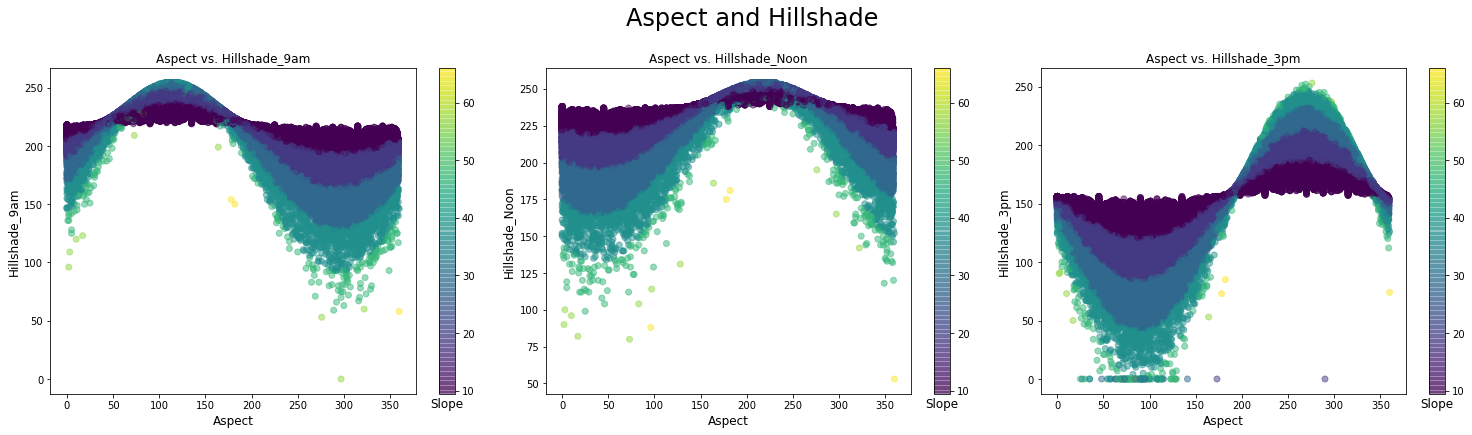

In [15]:
fig = plt.figure(figsize = (21,6))
fig.suptitle("Aspect and Hillshade", fontsize = 24, y = 1)

two_d_graph(cover_train, "Aspect", ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"], binner(cover_train, "Slope"))

plt.tight_layout()
plt.show()

All three hillshade features are sinusoidal functions of aspect with amplitude being a function of slope. This is more apparent when looking at all hillshade features at once below.

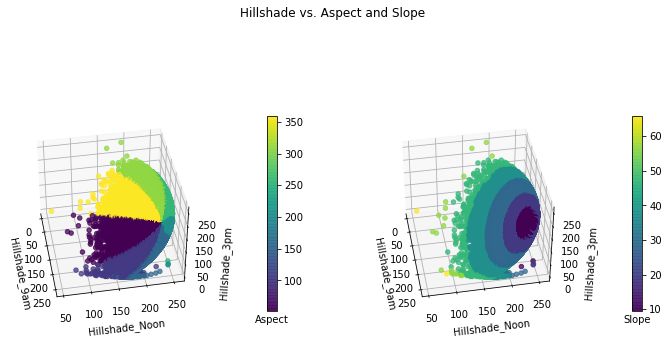

In [16]:
from mpl_toolkits.mplot3d import Axes3D

def three_d_graph(df, col1s, color_cols, title, elev, azim):
    fig = plt.figure(figsize = (12,6))
    fig.suptitle(title)
    counter = 1
    for col in color_cols:
        ax = fig.add_subplot(1,len(color_cols), counter, projection = "3d")
        g = ax.scatter(*[df[column].values[::5] for column in col1s], alpha = .75, c = binner(df, col)[::5])
        ax.set_xlabel(col1s[0])
        ax.set_ylabel(col1s[1])
        ax.set_zlabel(col1s[2])
        ax.view_init(elev = elev, azim = azim)
        ca = plt.colorbar(g, pad = .2, shrink = .6)
        ca.ax.set_xlabel(col, rotation = 0)
        counter+=1
    plt.show()
  
        
three_d_graph(cover_train, ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"],\
              ["Aspect", "Slope"], "Hillshade vs. Aspect and Slope", 40, -10)

From these graphs it is appears that the three hillshade features give the same information as aspect and slope and so some of these features can be left out during model creation.

In [17]:
cols_to_drop = [col for col in cover.columns.values if "Hillshade" in col]

num_column_names = [col for col in num_column_names if col not in cols_to_drop]

features = [col for col in features if col not in cols_to_drop]

cover_train = cover_train.drop(cols_to_drop, axis = 1)
cover_test = cover_test.drop(cols_to_drop, axis = 1)

In [18]:
#Soil vs. wilderness

pd.crosstab(cover_train.soil, cover_train.wilderness)

wilderness,1,2,3,4
soil,,,,
1,0,0,0,2432
2,0,0,4315,1697
3,0,0,1894,1962
4,0,0,8896,996
5,0,0,0,1257
6,0,0,0,5260
7,80,0,0,0
8,135,0,0,0
9,922,0,0,0


There are many zeros in this table. Wilderness 4 only has 12 soil types present out of the 40, but every wilderness type is missing at least ten soil types. It may make sense to split model training up via wilderness in order to reduce the number of feature dimensions.

## Relationships between features and cover type

Continuing on, it is worth checking the remaining features for relationships with the cover type.

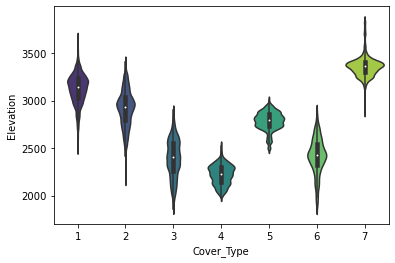

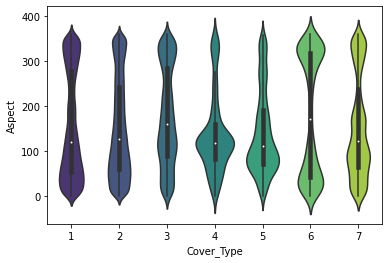

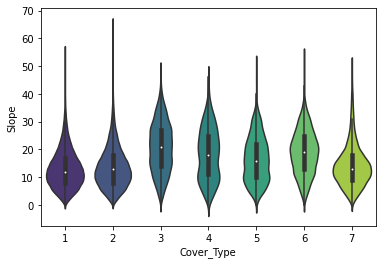

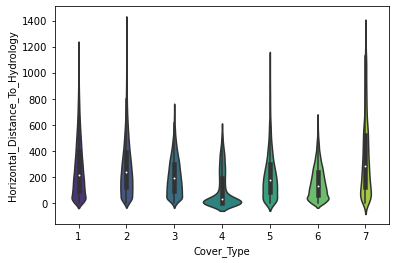

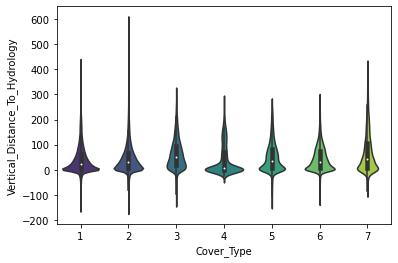

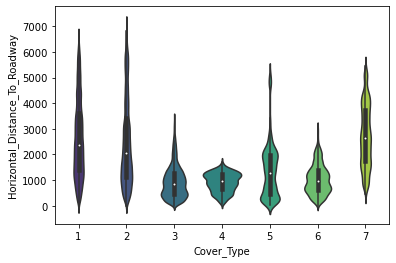

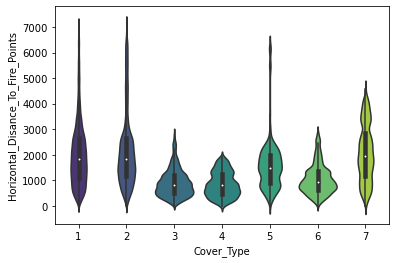

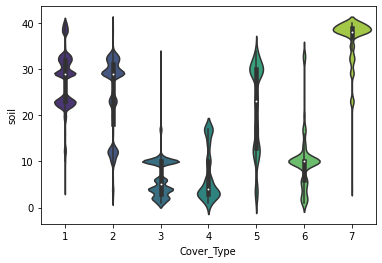

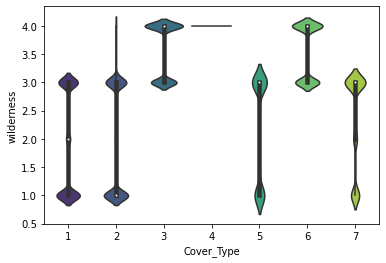

In [19]:
for feature in num_column_names + ["soil", "wilderness"]:
    sns.violinplot(data = cover_train, y = feature, x = "Cover_Type", palette = "viridis")
    plt.show()

Looking at the graphs, it is notable that Elevation changes have a large impact on the cover types that occur.
The distributions for cover types 1 and 2 are almost the same across most features. Aside from elevation and soil type, where there is some difference in the distribution, the instances where they are visibly different correspond to instances where there are few samples, see for example the highest values for distance to hydrology or slope, where cover type 2 has a more elongated, but very thin, distribution. This suggests that it may be difficult to separate the cover types in general, and since they make up a combinded 80% of all data points it may be difficult to get high accuracy in general. The best hope for this is that our models can look at multiple features together and work out how to separate these two cover types well.

We can also look at wilderness, soil, and cover type more closely.

In [20]:
#Wilderness vs. cover type

pd.crosstab(cover_train.wilderness, cover_train.Cover_Type)

Cover_Type,1,2,3,4,5,6,7
wilderness,,,,,,,
1,84449,116948,0,0,3017,0,4098
2,14820,7216,0,0,0,0,1854
3,70203,100082,11457,0,4577,6113,10456
4,0,2394,17146,2197,0,7780,0


Each wilderness type is missing at least one cover type. Notably, Cover type 4, the least prevalent cover type, is only present in wilderness type 4. This presents a potential method of singling it out if needed.

In [21]:
#Soil vs. cover type

pd.crosstab(cover_train.soil, cover_train.Cover_Type)

Cover_Type,1,2,3,4,5,6,7
soil,,,,,,,
1,0,0,1674,141,0,617,0
2,0,665,4006,95,211,1035,0
3,0,951,1939,811,0,155,0
4,155,2592,6004,137,452,494,58
5,0,0,757,39,0,461,0
6,0,717,3200,257,0,1086,0
7,0,80,0,0,0,0,0
8,30,105,0,0,0,0,0
9,136,786,0,0,0,0,0


Certain soil types correspond entirely to one cover type, so it may make sense to handle them separately, though they also are only a few samples.

# Modeling

## Preprocessing data
To start with we will split off a validation set from the test set, data transformation will be done within a function defined later.

In [23]:
##Preprocessing Imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [24]:
##Separate validation set from test set

g = cover_test.groupby("Cover_Type", group_keys = False)
val_ind = g.apply(lambda x: x.sample(int(.5 * len(x)), random_state = seed)).index

cover_valid = cover_test.loc[val_ind]
cover_valid = cover_valid.reset_index(drop = True)

cover_test = cover_test.loc[[i for i in cover_test.index if i not in val_ind]]
cover_test = cover_test.reset_index(drop = True)

print("Length of validation set: {}".format(len(cover_valid)))
print("Length of test set: {}".format(len(cover_test)))

Length of validation set: 58101
Length of test set: 58104


## Model creation

### Setup

Before training the models, we will define several helper functions.

In [25]:
#Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [26]:
##Define param grids

params = {}

params["FOREST"] = {"criterion": ["gini", "entropy"]}
params["LR"] = {"multi_class" : ["ovr", "multinomial"]}
params["SVM"] = {"C": [.5, 1]}
params["KNN"] = {"n_neighbors": [3, 5], "weights": ["uniform", "distance"], "p": [1,2]}

In [27]:
##Define balancing function to balance cover types.

def balancing(df, balanced = None):
    
    if balanced == "global":
        
        g = df.groupby("Cover_Type", group_keys = False)
        bal_ind = g.apply(lambda x: x.sample(df.Cover_Type.value_counts().min(), random_state = seed)).index

    if balanced == "wilderness":

        g = df.groupby(["wilderness", "Cover_Type"], group_keys = False)
        bal_ind = g.apply(lambda x: x.sample(df.groupby("wilderness", group_keys = False).\
                                             Cover_Type.value_counts().min(), random_state = seed)).index

    df = df.loc[bal_ind]
    
    return df

In [28]:
##Defining function to check different parameters.

def gridchecker(model, parameters, X, y):
    best_score = 0
    m = model
    for param in ParameterGrid(parameters):
        model.set_params(**param)
        model.fit(X,y)
        score = model.score(X[::3],y[::3])
        if score > best_score:
            best_score = score
            m = model
            
    return m

In [35]:
def GridSearchFit(df, split1 = 1, split2 = 1, types = ["FOREST", "LR", "SVM", "KNN"],\
                  params = params, wild_split = False, balanced = None, verbose = False):
    """
    Inputs:
        df: data frame of inputs and outputs
        split1: integer determining proportion of data used for training forest and logistic models
        split2: integer determining proportion of data used for training svm and knn models
        types: list of model types to be used in training
        params: dict of parameters to perform grid search over
        wild_split: boolean determining if data is split on wilderness before training
        balanced: boolean determining if data is downsampled for balanced output variable
        verbose: boolean determining amount of information printed during execution
        
    Outputs:
        Best_models: dictionary of best models trained by grid search
        Transformers: Transformer(s) used to transform inputs
        dropcols: list of columns to remove before applying transformer
    """
    
##Initializing output dicts

    Best_Models = {}
    Transformers = {}
    dropcols = {}
    
##Data balancing option

    if balanced in ["global", "wilderness"]:
        
        df = balancing(df, balanced)

##wild_split option

    L = []
    if wild_split:
        for i in range(4):
            L.append(df.loc[df.wilderness == (i+1)])
    else:
        L.append(df)
    
##Execution

    for i,f in enumerate(L):
        
##Split off outputs

        y = f["Cover_Type"]

##Drop unused columns

        A = f[features].std()
        remove = A.loc[A < 1e-5]
        remove = remove.index.to_list() + ["wilderness", "soil", "Cover_Type"]
        
        if verbose:
            print("Removing the following columns:\n")
            print(remove, "\n")
            
        f = f.drop(remove, axis = 1)
    
##Transform the data

        Transformer = ColumnTransformer([["MinMax" + col, MinMaxScaler(), [col]] for col in num_column_names],\
                                        remainder = "passthrough")
    
        X = Transformer.fit_transform(f)
        del f
##Create model instances

        Models = {}

        Models["FOREST"] = RandomForestClassifier()
        Models["LR"] = LogisticRegression(max_iter = 1000)
        Models["SVM"] = SVC(random_state = seed)
        Models["KNN"] = KNeighborsClassifier()
    
##Run grid search

        GS_Models = {}
        for model_type in types:

            print("Fitting {}".format(model_type))
        
            start = time.time()

            if model_type in ["FOREST"]:

                GS_Models[model_type] = gridchecker(Models[model_type], params[model_type], X[::split1], y[::split1])

            if model_type in ["SVM", "KNN", "LR"]:

                GS_Models[model_type] = gridchecker(Models[model_type], params[model_type], X[::split2], y[::split2])

            end = time.time()
        
            if verbose:
                print("Finished in {} seconds \n".format(round(end-start,2)))
                
##Add outcomes to output dicts

        Best_Models[i] = GS_Models
        Transformers[i] = Transformer
        dropcols[i] = remove
        
##Return models, transformer, and dropped columns

    return Best_Models, Transformers, dropcols

In [30]:
def model_evals(models, Transformers, dropcols, df):
    
    y_true = np.array([])
    y_preds = {model_type: np.array([]) for model_type in models[0].keys()}
    L = []
    
    if len(models) == 4:
        for i in range(4):
            L.append(df.loc[df.wilderness == (i+1)])
    else:
        L.append(df)
    for i,f in enumerate(L):
        
        y = f["Cover_Type"]
        y_true = np.append(y_true, y)
        X = f.drop(dropcols[i], axis = 1)
        X = Transformers[i].transform(X)

        for model_type in models[i].keys():
            
            y_pred = models[i][model_type].predict(X)
            y_preds[model_type] = np.append(y_preds[model_type], y_pred)
        
    return y_true, y_preds

### Unsplit models

To begin with, we will consider models trained using the unbalanced dataset, as well as models balanced for cover type at the global and wilderness level.

In [36]:
##Training Unsplit models

models_unbal = GridSearchFit(cover_train, 1, 40, verbose = False)

models_bal_global = GridSearchFit(cover_train, 1, 2, balanced = "global", verbose = False)

models_bal_wilderness = GridSearchFit(cover_train, 1, 2, balanced = "wilderness", verbose = False)

Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN


In [37]:
##Unsplit models evaluation

y_t1, y_p1 = model_evals(*models_unbal, cover_valid)

print("Unbalanced models:\n")

for model_type in y_p1.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t1, y_p1[model_type])))
    
y_t2, y_p2 = model_evals(*models_bal_global, cover_valid)

print("\nGlobally balanced models:\n")

for model_type in y_p2.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t2, y_p2[model_type])))

y_t3, y_p3 = model_evals(*models_bal_wilderness, cover_valid)

print("\nWilderness balanced models:\n")

for model_type in y_p3.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t3, y_p3[model_type])))

Unbalanced models:

FOREST balanced accuracy: 0.9292236706916508
LR balanced accuracy: 0.45366546227480786
SVM balanced accuracy: 0.46021834859871
KNN balanced accuracy: 0.6593260893845583

Globally balanced models:

FOREST balanced accuracy: 0.8834475932309915
LR balanced accuracy: 0.6570718430684584
SVM balanced accuracy: 0.6862424737899505
KNN balanced accuracy: 0.795491632940509

Wilderness balanced models:

FOREST balanced accuracy: 0.9008728281396383
LR balanced accuracy: 0.6347905238162571
SVM balanced accuracy: 0.6755460336830889
KNN balanced accuracy: 0.8183149166766926


The best model without splitting is the random forest trained with no data set balancing. Crosstabs for the two best unsplit models are shown below.

In [38]:
pd.crosstab(pd.Series(y_t1, name = "True Cover Type"), pd.Series(y_p1["FOREST"],name = "Predicted Cover Type"),\
            normalize = "index") ## Needs 2vs5 and 3vs4

Predicted Cover Type,1.0,2.0,3.0,4.0,5.0,6.0,7.0
True Cover Type,,,,,,,
1.0,0.959970,0.037812,0.000000,0.000000,0.000330,0.000047,0.001841
2.0,0.018037,0.977762,0.001447,0.000000,0.001412,0.001165,0.000176
3.0,0.000000,0.012867,0.964755,0.003636,0.000559,0.018182,0.000000
4.0,0.000000,0.000000,0.083636,0.883636,0.000000,0.032727,0.000000
5.0,0.005269,0.158061,0.008430,0.000000,0.826133,0.002107,0.000000
6.0,0.000000,0.020150,0.046056,0.002879,0.000576,0.930340,0.000000
7.0,0.034130,0.003901,0.000000,0.000000,0.000000,0.000000,0.961970


This model performs very well despite not having any balancing with cover types. It does suffer when evaluating cover types 4 and 5, however. Nearly 16% of cover type 5 is misclassified as type 2, and 8% of cover type 4 is misclassified as type 3.

In [39]:
pd.crosstab(pd.Series(y_t3, name = "True Cover Type"), pd.Series(y_p3["FOREST"],name = "Predicted Cover Type"),\
            normalize = "index") ## Needs 1vs2 and 3vs6

Predicted Cover Type,1.0,2.0,3.0,4.0,5.0,6.0,7.0
True Cover Type,,,,,,,
1.0,0.822932,0.119524,0.000472,0.000000,0.011424,0.001699,0.043948
2.0,0.131557,0.780127,0.014508,0.000000,0.049841,0.019732,0.004236
3.0,0.000000,0.025734,0.864895,0.023217,0.004196,0.081958,0.000000
4.0,0.000000,0.000000,0.021818,0.960000,0.000000,0.018182,0.000000
5.0,0.000000,0.029505,0.005269,0.000000,0.959958,0.005269,0.000000
6.0,0.000000,0.010363,0.047784,0.013241,0.001151,0.927461,0.000000
7.0,0.008776,0.000000,0.000000,0.000000,0.000488,0.000000,0.990736


This model struggles to differentiate between types 1 and 2, Each is misclassified as the other more than 10% of the time. Additionally, the model struggles with types 3 and 6.

### Split Models

In addition to the above, we can break up the model by wilderness type, which allows us to remove a large number of columns from each submodel since many soil types don't appear for a given wilderness type.

In [40]:
##Split model training

split_models_unbal = GridSearchFit(cover_train, 1, 10, wild_split = True, balanced = None, verbose = False)

split_models_bal_global = GridSearchFit(cover_train, 1, 1, wild_split = True, balanced = "global", verbose = False)

split_models_bal_wild = GridSearchFit(cover_train, 1, 1, wild_split = True, balanced = "wilderness", verbose = False)

Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN
Fitting FOREST
Fitting LR
Fitting SVM
Fitting KNN


In [41]:
##Split model evaluation

y_t4, y_p4 = model_evals(*split_models_unbal, cover_valid)

print("Unbalanced split models:\n")

for model_type in y_p4.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t4, y_p4[model_type])))    

y_t5, y_p5 = model_evals(*split_models_bal_global, cover_valid)

print("\nGlobally balanced split models:\n")

for model_type in y_p5.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t5, y_p5[model_type])))

y_t6, y_p6 = model_evals(*split_models_bal_wild, cover_valid)

print("\nWilderness balanced split models:\n")

for model_type in y_p6.keys():
    print("{} balanced accuracy: {}".format(model_type, balanced_accuracy_score(y_t6, y_p6[model_type])))

Unbalanced split models:

FOREST balanced accuracy: 0.9341992664156524
LR balanced accuracy: 0.523052899287704
SVM balanced accuracy: 0.5582261613418574
KNN balanced accuracy: 0.8020891320405854

Globally balanced split models:

FOREST balanced accuracy: 0.884183550337112
LR balanced accuracy: 0.6870292232907145
SVM balanced accuracy: 0.7572144656252541
KNN balanced accuracy: 0.8589364159419779

Wilderness balanced split models:

FOREST balanced accuracy: 0.9024066744429724
LR balanced accuracy: 0.6658507670008944
SVM balanced accuracy: 0.7575746268937256
KNN balanced accuracy: 0.883720893980139


The best split model is the random forest without cover type balancing. It performs better than the unsplit unbalanced model by about .05%. Crosstabs for the best two split models are shown below.

In [42]:
pd.crosstab(pd.Series(y_t4, name = "True Cover Type"), pd.Series(y_p4["FOREST"],name = "Predicted Cover Type"),\
            normalize = "index")

Predicted Cover Type,1.0,2.0,3.0,4.0,5.0,6.0,7.0
True Cover Type,,,,,,,
1.0,0.960961,0.037340,0.000000,0.000000,0.000189,0.000047,0.001463
2.0,0.018214,0.977586,0.001377,0.000000,0.001588,0.001059,0.000176
3.0,0.000000,0.011748,0.967552,0.003916,0.000280,0.016503,0.000000
4.0,0.000000,0.000000,0.083636,0.898182,0.000000,0.018182,0.000000
5.0,0.004215,0.152792,0.006322,0.000000,0.834563,0.002107,0.000000
6.0,0.000576,0.017847,0.043754,0.003454,0.001151,0.933218,0.000000
7.0,0.029254,0.003413,0.000000,0.000000,0.000000,0.000000,0.967333


In [100]:
pd.crosstab(pd.Series(y_t6, name = "True Cover Type"), pd.Series(y_p6["FOREST"],name = "Predicted Cover Type"),\
            normalize = "index")

Predicted Cover Type,1.0,2.0,3.0,4.0,5.0,6.0,7.0
True Cover Type,,,,,,,
1.0,0.825245,0.120091,0.000425,0.000000,0.011235,0.001605,0.041399
2.0,0.127744,0.783657,0.014543,0.000000,0.049276,0.020332,0.004448
3.0,0.000000,0.024615,0.869091,0.022937,0.003916,0.079441,0.000000
4.0,0.000000,0.000000,0.025455,0.952727,0.000000,0.021818,0.000000
5.0,0.000000,0.025290,0.005269,0.000000,0.965227,0.004215,0.000000
6.0,0.000000,0.007484,0.049511,0.011514,0.002303,0.929188,0.000000
7.0,0.007801,0.000000,0.000000,0.000000,0.000488,0.000000,0.991711


All four of the best models have problems with distinguishing between certain pairs of cover types. Those that are unbalanced have issues with 2vs5 and 3vs4, while the wilderness balanced models have problems with 1vs2 and 3vs6. It may be possible to improve these models based on this. For example, the wilderness balanced models may be improved by taking all predictions of types 1,2 and feeding them in to a model built to distinguish between those two types before getting a final prediction.

### Modifying the model

In [107]:
##Train models to differentiate between types 2 and 5 and between types 3 and 4.

s25 = GridSearchFit(cover_train.loc[cover_train.Cover_Type.isin([2,5])], types = ["FOREST"], wild_split = False, balanced = "global", verbose = True)

s34 = GridSearchFit(cover_train.loc[cover_train.Cover_Type.isin([3,4])], types= ["FOREST"], wild_split = False, balanced = "global", verbose = True)

Removing the following columns:

['Soil_1', 'Soil_5', 'Soil_14', 'Soil_15', 'Soil_37', 'wilderness', 'soil', 'Cover_Type'] 

Fitting FOREST
Finished in 2.81 seconds 

Removing the following columns:

['Wilderness_1', 'Wilderness_2', 'Soil_7', 'Soil_8', 'Soil_9', 'Soil_12', 'Soil_15', 'Soil_18', 'Soil_19', 'Soil_20', 'Soil_21', 'Soil_22', 'Soil_23', 'Soil_24', 'Soil_25', 'Soil_26', 'Soil_27', 'Soil_28', 'Soil_29', 'Soil_30', 'Soil_31', 'Soil_33', 'Soil_34', 'Soil_35', 'Soil_36', 'Soil_37', 'Soil_38', 'Soil_39', 'Soil_40', 'wilderness', 'soil', 'Cover_Type'] 

Fitting FOREST
Finished in 0.75 seconds 



In [165]:
def Cover_Type_Model(df):
    
    mods, transformers, dropcols = split_models_unbal
    new_mods = {i: {"FOREST": mods[i]["FOREST"]} for i in mods.keys()}
    
    y_true, initial_preds = model_evals(new_mods, transformers, dropcols, df)
    forest_preds = initial_preds["FOREST"]
    
##Get data samples predited as 2/5 or 3/4

    mask25 = [forest_preds[i] in [2,5] for i in range(len(df))]

    mask34 = [forest_preds[i] in [3,4] for i in range(len(df))]

    A = df.rename_axis("idx").sort_values(by = ["wilderness", "idx"], ascending = [True, True])
    B = A.iloc[mask25]
    C = A.iloc[mask34]

##Get new predictions

    y_t25, y_p25 = model_evals(*s25, B)

    y_t34, y_p34 = model_evals(*s34, C)

    y_preds_25 = y_p25["FOREST"]

    y_preds_34 = y_p34["FOREST"]

##Get passthrough results

    mask_neg = [not i for i in (np.array(mask25) + np.array(mask34))]

    y_true_not2534 = y_true[mask_neg]
    y_preds_not2534 = forest_preds[mask_neg]

    y_true_25 = y_true[mask25]
    y_true_34 = y_true[mask34]
    
##Combine results

    y_true_comb = np.append(y_true_not2534, y_true_25)
    y_true_comb = np.append(y_true_comb, y_true_34)
    y_preds_comb = np.append(y_preds_not2534, y_preds_25)
    y_preds_comb = np.append(y_preds_comb, y_preds_34)
    

    df = A.iloc[mask_neg]

    Df = pd.concat([df,B,C], ignore_index = True)


##Evaluate model

    print("Balanced accuracy score: {}".format(balanced_accuracy_score(y_true_comb, y_preds_comb)))
    print("Accuracy score: {}".format(accuracy_score(y_true_comb, y_preds_comb)))
    
    return pd.Series(y_true_comb, name = "Cover Type True"), pd.Series(y_preds_comb, name = "Cover Type Predicted"), Df
    

In [164]:
valid_true, valid_pred, df = Cover_Type_Model(cover_valid)

pd.crosstab(valid_true, valid_pred, normalize = "index")

Balanced accuracy score: 0.9534927632712479
Accuracy score: 0.947677320528046


Cover Type Predicted,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Cover Type True,,,,,,,
1.0,0.960961,0.036018,0.000000,0.000000,0.001511,0.000047,0.001463
2.0,0.018214,0.937593,0.001377,0.000000,0.041581,0.001059,0.000176
3.0,0.000000,0.010070,0.935944,0.035524,0.001958,0.016503,0.000000
4.0,0.000000,0.000000,0.018182,0.963636,0.000000,0.018182,0.000000
5.0,0.004215,0.011591,0.006322,0.000000,0.975764,0.002107,0.000000
6.0,0.000576,0.015544,0.042602,0.004606,0.003454,0.933218,0.000000
7.0,0.029254,0.003413,0.000000,0.000000,0.000000,0.000000,0.967333


The process of filtering predictions through additional models has raised the balanced accuracy score from 93.42% to 95.35%, an increase of almost 2%. Next the model will be tested on the test set. Of note, nearly all of the instances where type 5 was classified as type 2 (15% of the time before) is now correctly classified. There was some trade off in that now roughly 4% of type 2 is misclassified as type 5, but overall this is an improvement.

In [163]:
test_true, test_pred, test_df = Cover_Type_Model(cover_test)

pd.crosstab(test_true, test_pred, normalize = "index")

Balanced accuracy score: 0.9511616208946804
Accuracy score: 0.9483512322731653


Cover Type Predicted,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Cover Type True,,,,,,,
1.0,0.961952,0.034979,0.000047,0.000000,0.001369,0.000047,0.001605
2.0,0.015425,0.939819,0.001694,0.000000,0.041862,0.000988,0.000212
3.0,0.000000,0.012304,0.931767,0.034955,0.005034,0.015940,0.000000
4.0,0.000000,0.000000,0.007273,0.963636,0.000000,0.029091,0.000000
5.0,0.004211,0.007368,0.009474,0.000000,0.976842,0.002105,0.000000
6.0,0.001151,0.015544,0.046056,0.009211,0.003454,0.924583,0.000000
7.0,0.034130,0.005851,0.000000,0.000000,0.000488,0.000000,0.959532


On the test set, the model reaches just over 95% balanced accuracy and just under 95% accuracy. This is nearly the same as was reached on the validation set, which suggests we did not overfit to it.